In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from target import build_tgt_matrix
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
selected_009266

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-05-04_09-11-06',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [22]:
session = selected_009266[2]
all_areas = ['A1', 'PPC', 'HPC']

animal      = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
aeps_file   = os.path.join(sessionpath, 'AEPs.h5')
h5_file     = os.path.join(sessionpath, session + '.h5')
report_path = os.path.join(report, 'PSTH', session)
if not os.path.exists(report_path):
    os.makedirs(report_path)
session

'009266_hippoSIT_2023-04-18_17-03-10'

In [23]:
with h5py.File(h5_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    cfg = json.loads(f['processed'].attrs['parameters'])

envelopes = {}
with h5py.File(aeps_file, 'r') as f:
    for area in all_areas:
        if not area in f:
            continue
        envelopes[area] = np.array(f[area]['LFP4Hz']['envelope'])
    aeps_events = np.array(f['aeps_events'])
    
areas = list(envelopes.keys())

In [24]:
# # load metrics
AEP_metrics_lims = dict([(area, {}) for area in areas])
AEP_metrics_raw  = dict([(area, {}) for area in areas])
AEP_metrics_norm = dict([(area, {}) for area in areas])
with h5py.File(aeps_file, 'r') as f:
    for area in areas:
        grp = f[area]

        for metric_name in grp['norm']:
            AEP_metrics_raw[area][metric_name]  = np.array(grp['raw'][metric_name])
            AEP_metrics_norm[area][metric_name] = np.array(grp['norm'][metric_name])
            AEP_metrics_lims[area][metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]

In [25]:
aeps_tl_idxs = []  # idxs to timeline for AEP events
for event_t in aeps_events[:, 0]:  # AEP event times
    event_idx = (np.abs(tl[:, 0] - event_t)).argmin()
    aeps_tl_idxs.append(event_idx)
aeps_tl_idxs = np.array(aeps_tl_idxs)

bgr_aep_idxs = np.where(aeps_events[:, 1] == 1)[0]
tgt_aep_idxs = np.where(aeps_events[:, 1] == 2)[0]

## LFP 4Hz vs AEP metrics

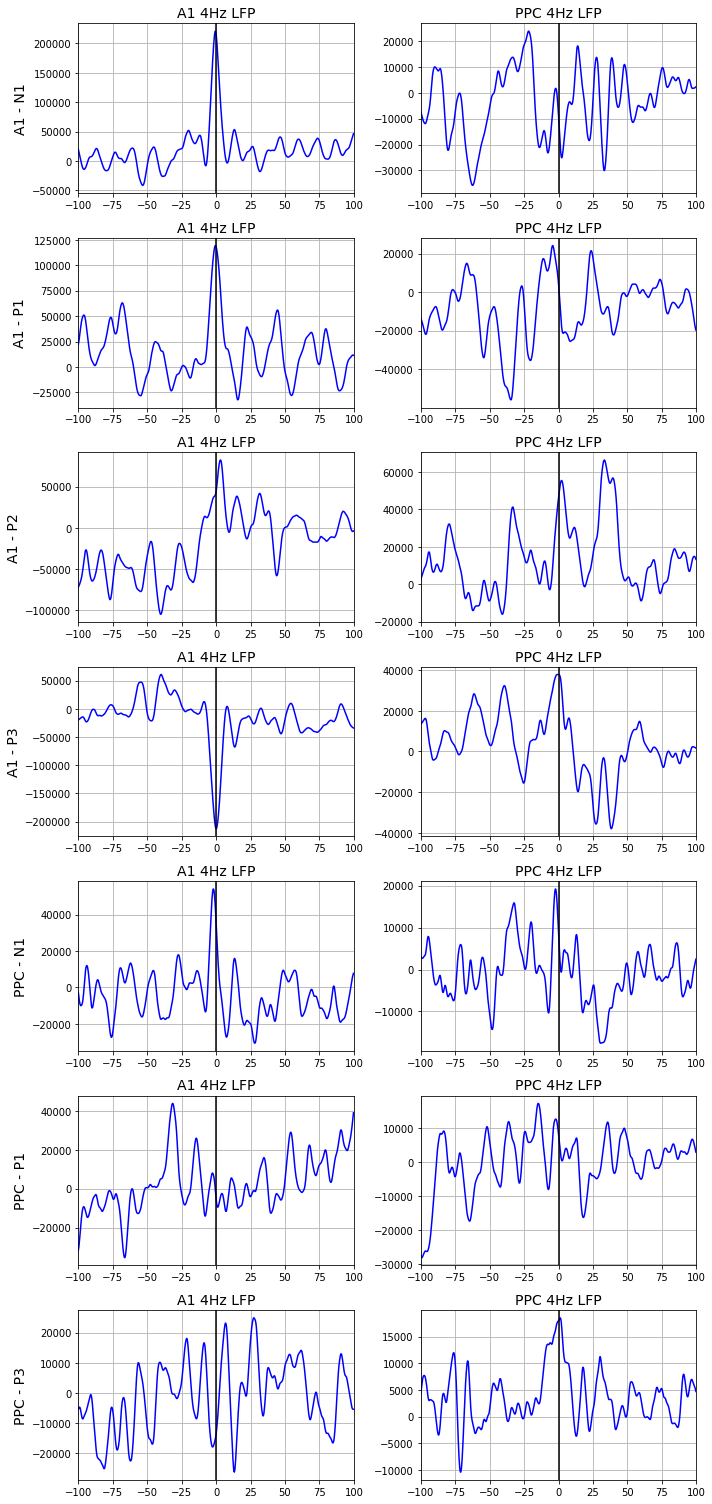

In [26]:
s_rate  = 4
t_lag   = 100  # seconds
columns = len(areas)
rows    = np.array([len(AEP_metrics_norm[area].keys()) for area in areas]).sum()

fig = plt.figure(figsize=(10, 3*rows))

for i, area in enumerate(areas):
    metric1 = envelopes[area][::10][aeps_tl_idxs]  # downsample + take only at AEPs
    
    count = 0
    for m_area in areas:
        metric_names = list(AEP_metrics_norm[m_area].keys())
        for m_name in metric_names:
            metric2 = AEP_metrics_norm[m_area][m_name]

            corr = signal.correlate(metric1, metric2)
            lags = signal.correlation_lags(len(metric2), len(metric1))
            idx_l, idx_r = int(len(lags)/2) - t_lag*s_rate, int(len(lags)/2) + t_lag*s_rate

            ax = fig.add_subplot(rows, columns, count*columns + i+1)
            ax.plot(lags[idx_l:idx_r]/s_rate, corr[idx_l:idx_r], color='blue')

            if i == 0:
                ax.set_ylabel("%s - %s" % (m_area, m_name), fontsize=14)
            ax.set_title("%s 4Hz LFP" % area, fontsize=14)
            ax.axvline(0, color='black')
            ax.set_xlim(-t_lag, t_lag)
            ax.grid()
            count += 1

fig.tight_layout()
fig.savefig(os.path.join(report_path, 'CCR_LFP4Hz_AEPs.pdf'))